              precision    recall  f1-score   support

       cubic       0.74      0.43      0.54      2926
orthorhombic       0.46      0.49      0.47      1415
rhombohedral       0.10      0.33      0.15       291
  tetragonal       0.07      0.34      0.11       116

    accuracy                           0.44      4748
   macro avg       0.34      0.40      0.32      4748
weighted avg       0.60      0.44      0.49      4748



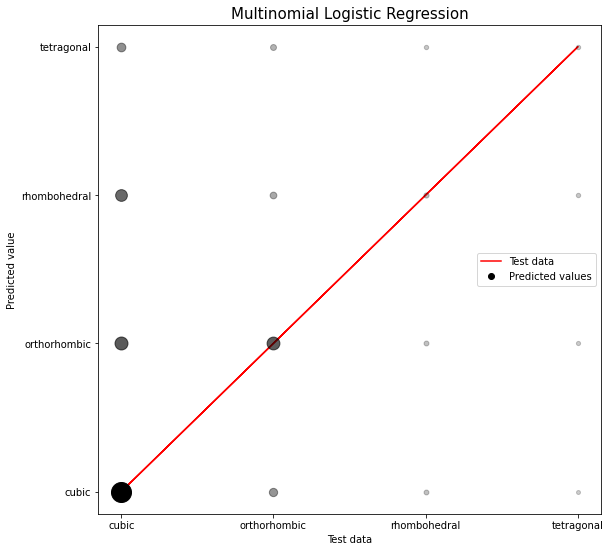

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
import math
import sklearn.metrics as metrics

class Preprocessor():
    def __init__(self, file_directory: str, drop_list: list, not_number: list, filetype: str = "csv", 
                 encodetype: str = "label", useScaler: bool = False, scaletype: str = "minmax", 
                 replaceNAN: bool = True):
        """Init function
            Inputs: 
            file_directory: directory of the file relative to script.
            filetype: type of file to be imported (defaulted as csv).
            drop_list: list of columns to omit from the preprocessed data.
            not_number: list of columns that are worded for encoded (EXCEPT last column)
            encodetype: type of encoder to be used (ONLY onehot or label). Defaulted to label
            useScaler: boolean that states whether the data should be scaled or not
            scaletype: type of scaler to be used if useScalercaler is true (ONLY minmax and standard)
            replaceNAN: true if all N/A values should be replaced by the mean of the column, false if row
            containing N/A should be omitted (defaulted to true).
            
            Returns: None"""
        
        # add attributes
        self.dir = file_directory
        self.worded = not_number
        self.drop_list = drop_list
        self.filetype = filetype
        self.scale = useScaler
        self.replaceNAN = replaceNAN
        
        # make sure encodetype is either onehot or label
        encode_check = encodetype in ("onehot", "label")
        assert encode_check, f"Unexpected encode type '{encodetype}'. Preprocessor only takes onehot or label encoding"
        # add encoder attribute
        self.encodetype = encodetype
        
        # only run if useScaler is true, else scaletype won't be defined.
        if(useScaler == True):
            # make sure scaletype is either minmax or standard
            scale_check = scaletype in ("minmax", "standard")
            assert scale_check, f"Unexpected scaling type '{scaletype}'. Preprocessor only takes minmax or standard scaling"
            # add scaler attribute
            self.scaletype = scaletype
        
    

    def Process(self) -> pd.DataFrame:
        """Calls all other functions within class and runs until a 
            clean, encoded, scaled Dataframe is returned to the user
            Inputs: 
            self: contains attributes (refer to notes at __init__)
            
            Returns: pandas dataframe of fully preprocessed data"""
        
        # first we import the file:
        raw_data = self.ImportAsDf()
        # we then clean the data:
        clean_data, worded_columns = self.CleanData(raw_data)
        # next we encode the necessary worded columns:
        encoded_data = self.Encode(clean_data, worded_columns)
        
        # if useScaler is true, scale the non-encoded numerated data:
        if(self.scale == True):
            # get list of non-encoded numerated columns
            numbered_columns = [i for i in encoded_data.columns if i not in worded_columns]
            
            # scale data
            scaled = self.Scale(encoded_data, numbered_columns)
            return scaled
        
        else: return encoded_data
    
    
    def ImportAsDf(self) -> pd.DataFrame:
        """Grabs file and imports it as a pandas Dataframe.
            Inputs: 
            self: contains attributes (refer to notes at __init__).

            Returns: pandas dataframe of the raw data"""

        if(self.filetype == "csv"):
            return pd.read_csv(self.dir)
        return None

    
    def CleanData(self, data: pd.DataFrame) -> tuple:
        """Goes through the data and removes/replaces any N/A values, as well
           returning any worded columns to to be encoded.
            Inputs: 
            self: contains attributes (refer to notes at __init__).
            data: data to be cleaned. 

            Returns: tuple: 
                   0: pandas dataframe of the cleaned data
                   1: list of all worded columns to be encoded"""

        #reset index of data 
        data = data.reset_index(drop=True)
        #remove unnecessary columns
        data = data.drop(self.drop_list, axis=1)
        #replace all "-" with NAN
        data = data.replace("-", np.nan)

        #get two lists of columns split on whether their values are numbers or not:
        worded_columns = [i for i in self.worded if i in data] # makes sure worded columns that were dropped do not appear
        numerated_columns = [i for i in data.columns if i not in worded_columns]

        # we first search through worded columns and remove row where NA is present, since mean method will not work:
        for column in worded_columns:
            removal_list=[]
            
            # go through every value in worded column
            for i, value in enumerate(data[column]):
                
                # add row index of each occurance of NAN
                if(pd.isna(value)): removal_list.append(i)
            
            # remove once iteration is complete to avoid issues with index i:
            data.drop(removal_list, inplace=True)

        
        # we then search through numbered columns, and either replace NA with a mean or remove column    
        if(self.replaceNAN== True):
            for column in numerated_columns:
                #find mean of column (convert all values in columns to floats before averaging)
                column_mean = data[column].astype(float).mean(skipna= True)
                
                #replace na values on column with mean
                data[column] = data[column].apply(lambda x: column_mean if pd.isna(x) == True else x)
            
            return (data.reset_index(drop=True), worded_columns)
        
        
        else: # remove NA values if repalce is set to false:
            return (data.dropna().reset_index(drop=True), worded_columns)

    
    def Encode(self, data: pd.DataFrame, encode_columns: list) -> pd.DataFrame:
        """Encodes columns either using a label encoder or a onehot encoder.
            Inputs:
            self: contains attributes (refer to notes at __init__)
            data: data to be encoded.
            encode_columns: list of columns by label to be encoded
            
            Returns:
            Pandas dataframe of the encoded data"""
        
        # exclude final column from being encoded since it is the dependant variable
        encode_columns = encode_columns[:-1]
        
        #check if onehot or label encoder is being used
        if(self.encodetype == "onehot"):
            for column in encode_columns:
                # grab a list of distinct categories
                categories = sorted(set(data[column]))
                
                # go through each category and make a new column with binary values 0 or 1
                for category in categories:
                    data[f"{column}_{category}"] = data[column].apply(lambda x: 1 if x == category else 0)
                
                #drop column
                data.drop(column, axis=1, inplace = True)
                
            return data
        
        else: # must be label due to previous assertion
            for column in encode_columns:
                # grab a list of distinct categories
                categories = sorted(set(data[column]))
                
                # map these categories to integers:
                category_map = {categories[i] : i for i in range(len(categories))}
                
                # apply value using the map
                data[column] = data[column].apply(lambda x: category_map[x])
            
            return data
    
    
    def Scale(self, data: pd.DataFrame, scale_columns: list) -> pd.DataFrame:
        """Scales the data based on the minmax or standard approach
            Inputs:
            self: contains attributes (refer to notes at __init__)
            data: data to be scaled.
            scale_columns: list of columns by label to be scaled
            
            Returns:
            Pandas dataframe of the scaled data"""
        
        # check if minmax or standard scaler is being used
        if (self.scaletype == "minmax"):
            # for each column of the data find the minimum and maximum values:
            for column in scale_columns:
                # make all values in column a float
                data[column] = data[column].astype(float)
                
                min_value, max_value = (data[column].min(), data[column].max())
                column_range = max_value - min_value
                
                # change data using minmax equation:
                data[column] = data[column].apply(lambda x: (x - min_value)/column_range)
            
            return data
        
        else: # must be standard due to previous assertion
            # for each column of the data, find the mean and standard deviation
            for column in scale_columns:
                # make all values in column a float
                data[column] = data[column].astype(float)
                
                mean, std = (data[column].mean(), data[column].std())
                
                # change data using standard equation:
                data[column] = data[column].apply(lambda x: (x - mean)/std)
            
            return data




# create list of worded columns and list of columns to drop
classes = ["Compound", "A", "B", "In literature", "Lowest distortion"]
drop_list = ["Compound", "In literature", "A", "B"]

file_directory = "Crystal_structure.csv"

# get preprocessed data
clean = Preprocessor(file_directory, drop_list, classes, replaceNAN = True, 
                     useScaler = True, scaletype = "standard").Process()



def SplitData(data: pd.DataFrame, train_ratio: float = 0.1) -> tuple:
    """Splits data into train and test samples
        Inputs:
        data: data to be split
        train_ratio: the ratio of train to test array size for the data.
        (defaulted to 10% train with 90% test data)
        
        Returns: tuple:
                 0: pandas DataFrame of train data for independent variables.
                 1: pandas DataFrame of test data for independent variables.
                 2: pandas Series of train data for dependent variable.
                 3: pandas Series of test data for dependent variable."""
    
    # find index where data should be split
    index = int(train_ratio * len(data.index))
    
    # Make a list of dependent and independant variables:
    X_columns = list(data.columns)
    y_columns = X_columns.pop(-1)
    
    # split X and y data into test and training data for each
    train = data.sample(frac=train_ratio, random_state = 200)
    test = data.drop(train.index)
    
    return train[X_columns], test[X_columns], train[y_columns], test[y_columns]
    


def KNN(data: tuple) -> knn: 
    """post-test note: KNN regression for this exact data is unreliable, since the data is highly imbalanced.
       
       K nearest neighbours algorithm that classifies the test data and returns the classifier with the best
       value of K
        Inputs:
        data: tuple of train and test data for both dependent and independent variables
        
        Returns:
        sklearn.neighbors.KNeighborsClassifier object of the classifier with the highest f1 score"""
    
    # unpack the split data
    X_train, X_test, y_train, y_test = data
    
    
    # find an appropriate number to use for k
    # go through knn algorithm for different k to find the best value of k between 1 and a limit
    limit = int(math.sqrt(len(y_test)))
    
    regressor_dict = {}
    
    for k in range(limit): # we must only use odd numbers so 2k+1 will be used as index
        # initate knn and fit classifier to the data:
        classifier = knn(n_neighbors = (2*k)+1, p=2, metric = "euclidean")
        classifier.fit(X_train, y_train)
        
        # predict y for test data and compare to real y data:
        y_pred = classifier.predict(X_test)
        score = metrics.f1_score(y_test, y_pred, average = "micro")
        
        # add classifier with their score into dictionary
        regressor_dict[classifier] =  score

    # return the key with the highest value:
    best_classifier = max(regressor_dict, key=regressor_dict.get)
    best_k = best_classifier.n_neighbors
    
    print(f"\n Best value of k for KNN is: {best_classifier.n_neighbors} \n")
    
    # re-predict y and collect a general metric report
    best_y_pred = best_classifier.predict(X_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)

    # Visualise the deviation of predicted data from real data
    VisualisePrediction(y_test, best_y_pred, f"K Nearest Neighbours: K = {best_k}" ,alpha_min = 0.2)
    
    return best_classifier
    


def Logistic(data: tuple) -> LogisticRegression:
    """post-test note: Performes better than KNN, but still has a low f1 score
       
       Multinomial logsitic regression that classifies the test data and returns the classifier
        Inputs:
        data: tuple of train and test data for both dependent and independent variables
        
        Returns:
        sklearn.linear_model.LogisticRegression object of the classifier"""
    
    # unpack the split data
    X_train, X_test, y_train, y_test = data

    # initiallise a multinomial logistic regression and fit to training set
    classifier = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000) 
    classifier.fit(X_train, y_train)

    # calculate prediction and print a report
    y_pred = classifier.predict(X_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)

    # Visualise the deviation of predicted data from real data
    VisualisePrediction(y_test, y_pred, "Multinomial Logistic Regression", alpha_min = 0.2)
    
    return classifier
    

    
def VisualisePrediction(y_test: pd.Series, y_pred: pd.Series, classifier_name: str, alpha_min: float = 0.5,) -> None:
    """Visualises prediction of classification algorithm by comparing the real value of the
       dependant variable with the one predicted by the algorithm and plotting the deviation
       of one from the other. Plots the points as a density map, with higher number of points 
       for a coordinate being darker and larger.
        Inputs: 
        y_test: pandas series of the real values of the dependent variable.
        y_pred: pandas series of the predicted values of dependent variable.
        classifier_name: the name of classifier used to generate y_pred. Used as the title of the plot.
        alpha_min: float of the minimum alpha value for the density plot.
        
        Returns: None"""
    
    # create dataframe of y_test and y_pred
    data = pd.DataFrame({"test": y_test, "pred": y_pred})
    
    count_dict = {}
    # go through each category present in test data:
    for test_category in set(data["test"]):
        # go through each category in predicted data:
        for pred_category in set(data["pred"]):
            # get a dataframe with only occurances of a specific coordinate, 
            # and find the number of occurances of this coordinate
            coordinate_data = data[(data["test"] == test_category) & (data["pred"] == pred_category)]
            no_occurances = len(coordinate_data)
            
            # add coordinate with their count into a dictionary
            count_dict[(test_category, pred_category)] = no_occurances
        
    
    # find coordinates with maximum and minimum counts
    max_key, min_key = (max(count_dict, key = count_dict.get), min(count_dict, key = count_dict.get))
    max_count, min_count = (count_dict[max_key], count_dict[min_key])
    
    # create new dataframe of unique rows, these will be our coordinates
    set_data = data.drop_duplicates(inplace = False)
    
    # set a quick min-max scaler that will scale all the counts to an alpha range
    for key in count_dict.keys():
        # first grab the value of the key
        count = count_dict[key]
        
        # then we apply a special min-max scaler using max of 1 and min of alpha_lower
        count_range = max_count - min_count
        alpha_range = 1 - alpha_min
        
        min_diff = count - min_count
        
        # compute scaled value and replace in dictionary
        alpha = (min_diff)/(count_range) * alpha_range + alpha_min
        count_dict[key] = alpha
        
    
    # create figure and axes
    fig, ax = plt.subplots(figsize = (9,9))
    
    # plot the y_test reference values into the figure
    ax.plot(y_test, y_test, "r-", label = "Test data")
    
    # plot each coordinate of the y_test - y_pred plot individually with alpha set:
    for coordinates, alpha in count_dict.items():
        test, pred = (coordinates[0], coordinates[1])
        ax.plot(test, pred, "ko", alpha = alpha, markersize = 20*alpha)
    
    # set title and labels
    ax.set_title(classifier_name, fontsize = 15)
    ax.set_ylabel("Predicted value")
    ax.set_xlabel("Test data")
    
    # create empty line for legend
    ax.plot(0, 0, "ko", label = "Predicted values")
    
    # show legend and figure
    ax.legend()
    

# split data
split_data = SplitData(clean)

# run Logistic/KNN algorithm and return score measures
classifier = Logistic(split_data)